In [38]:
import scipy.optimize
from qutip import *
from itertools import combinations,product
import numpy as np
from functools import partial
import matplotlib
from matplotlib import pyplot as plt
from math import sqrt
from multiprocessing import Pool
from tqdm import tqdm
from time import time

font = {'size'   : 20}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 8, 6
plt.rcParams['figure.dpi'] = 70
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

### Non-interacting probability distribution

$$
G(\omega) = \frac{1}{\omega - \epsilon_d - \Sigma_0 + i\Gamma}
$$

At $\Sigma = -\epsilon_d$, this becomes
$$
G(\omega) = \frac{1}{\omega + i\Gamma} \implies \rho_0 = \frac{1}{\pi} \frac{\Gamma^2}{\omega^2 + \Gamma^2}
$$

In [39]:
def get_H0_nu(w_range, gamma, sigma_0, ed, U, n):

    def func_proxy(bnu, x):
        sum = 0
        for b in combinations(bnu, n-1):
            prod = 1
            for bi in b:
                prod *= (x-bi)
            sum += prod
        return sum

    def func(bnu, x):
        sum = 0
        for i in bnu:
            sum += 1/(x - i)
        return abs(sum)


    count = 0
    while True:
        try:
            np.random.seed()
            rho = (1/np.pi)*gamma**2/(gamma**2 + (w_range - ed - sigma_0)**2)
            bnu = np.random.choice(w_range, size=n, replace=False, p=rho/sum(rho))
            func_partial = partial(func_proxy, bnu)
            np.random.seed()
            np.seterr(divide='ignore', invalid='ignore')
            Ek_nu = np.round(scipy.optimize.broyden2(func_partial, np.random.randn(n-1), f_tol=1e-10), 3)
            np.seterr(divide='warn', invalid='warn')
            if len(np.unique(Ek_nu)) == n-1:
                break
        except:
#             print ("Exception")
            pass
#     print ("Failed attempts:", count)
    Vk_nu = [1/sqrt(sum((Ek - bnu)**(-2))) for Ek in Ek_nu]
    e0_nu = np.mean(bnu)
    U_nu = U
    ed_nu = e0_nu - sigma_0
    return e0_nu, Ek_nu, Vk_nu, ed_nu, U_nu

In [40]:
def get_ham(Ek_0, Vk, ed, U):
    H_d = 0
    H_k = 0
    H_v = 0
    dim = len(Ek_0)
    H_d += ed*tensor([create(2)*destroy(2), identity(2)] + [identity(2)]*2*dim)
    H_d += ed*tensor([identity(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    H_d += U*tensor([create(2)*destroy(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    for i in range(dim):
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [create(2)*destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), create(2)*destroy(2)] + [identity(2)]*2*(dim - i - 1)))
        H_v += Vk[i] * tensor([create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1))
        H_v += Vk[i] * tensor([identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1))
    return H_d + H_k + H_v + H_v.dag()

In [41]:
def occ_RLM(Ek_0, Vk, e0):
    H_k = 0
    H_v = 0
    dim = len(Ek_0)
    H_d = 0
    H_d += e0*tensor([create(2)*destroy(2), identity(2)] + [identity(2)]*2*dim)
    H_d += e0*tensor([identity(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    for i in range(dim):
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [create(2)*destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)))
        H_k += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), create(2)*destroy(2)] + [identity(2)]*2*(dim - i - 1)))
        H_v += Vk[i] * tensor([create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1))
        H_v += Vk[i] * tensor([identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1))
        
    H = H_d + H_k + H_v + H_v.dag()
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    Xgs = X[0]
    cup = [tensor([identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(len(Ek_0) - i)) for i in range(len(Ek_0)+1)]
    cdn = [tensor([identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(len(Ek_0) - i)) for i in range(len(Ek_0)+1)]
    n_up = [c_up.dag()*c_up for c_up in cup]
    n_dn = [c_dn.dag()*c_dn for c_dn in cdn]
#     nup = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_up])
#     ndn = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_dn])
    nup = sum([np.real((Xgs.dag()*n_op*Xgs)[0][0][0]) for n_op in n_up])
    ndn = sum([np.real((Xgs.dag()*n_op*Xgs)[0][0][0]) for n_op in n_dn])
    return nup+ndn


In [42]:
def G_nu(w_range, E, X, Ek_nu, Vk_nu, e0_nu):
    delta = 0.05
    E0 = min(E)
    cup = [tensor([identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(len(Ek_nu) - i)) for i in range(len(Ek_nu)+1)]
    cdn = [tensor([identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(len(Ek_nu) - i)) for i in range(len(Ek_nu)+1)]
    n_up = [c_up.dag()*c_up for c_up in cup]
    n_dn = [c_dn.dag()*c_dn for c_dn in cdn]
    X0 = X[np.where(E == min(E))]
    X0_single = []
    try:
        n_RLM = occ_RLM(Ek_nu, Vk_nu, e0_nu)
    except:
        return [], False
    for Xgs in X0:
        nup = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_up])
        ndn = sum([np.round(np.real((Xgs.dag()*n_op*Xgs)[0][0][0]), 1) for n_op in n_dn])
        if abs(nup+ndn - n_RLM) < 10**(-10):
            X0_single.append(Xgs)
    if X0_single == []:
        return [], False

    Gnu = 0*w_range
    coeffs = []
    dens = []
    for (En, Xn), X0_ in product(zip(E,X), X0_single):
        c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*(len(X0_.dims[0])-2))
        C1 = X0_.dag()*c0_up*Xn
        C1_sq = np.real((C1*C1.dag())[0][0][0])
        C2 = Xn.dag()*c0_up*X0_
        C2_sq = np.real((C2*C2.dag())[0][0][0])
        x1 = w_range + E0 - En
        x2 = w_range + En - E0
#         Gnu += (1/(delta*sqrt(np.pi)))*(C1_sq*np.exp(-(x1/delta)**2) + C2_sq*np.exp(-(x2/delta)**2))/len(X0_single)
        Gnu += C1_sq/x1 + C2_sq/x2
    return Gnu, True


def sigma_nu(w_range, Gnu, e0_nu, Vk_nu, Ek_nu, sigma_0):
    G_nu_0_inv = w_range - e0_nu  - sum([Vk**2/(w_range - Ek) for Vk, Ek in zip(Vk_nu, Ek_nu)])
    sigma_nu = G_nu_0_inv - 1/Gnu + sigma_0
    return sigma_nu

100%|██████████| 500/500 [02:12<00:00,  3.76it/s]

Acceptance rate:  56.8 %
False


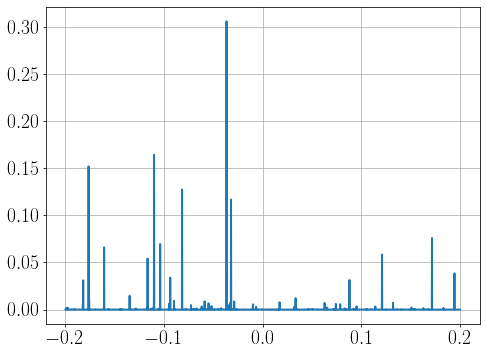

 27%|██▋       | 136/500 [00:36<01:38,  3.68it/s]Process ForkPoolWorker-374:
Traceback (most recent call last):
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-43-9179bfb20847>", line 32, in sample
    Gnu, flag = G_nu(w_range, E, X, Ek_nu, Vk_nu, e0_nu)
Process ForkPoolWorker-380:
  File "<ipython-input-42-f3aea15ab3bc>", line 29, in G_nu
    C2 = Xn.dag()*c0_up*X0_
Traceback (most recent call last):
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/qobj.py", line 513, in __mul__
    out = Qobj()
  

KeyboardInterrupt: 

  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/qobj.py", line 360, in __init__
    if self.type == 'super' and self.superrep is None:
  File "/home/abhirup/miniconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/qobj.py", line 2058, in type
    self._type = type_from_dims(self.dims)
  File "<ipython-input-43-9179bfb20847>", line 32, in sample
    Gnu, flag = G_nu(w_range, E, X, Ek_nu, Vk_nu, e0_nu)
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/dimensions.py", line 65, in type_from_dims
    bra_like, ket_like = map(is_scalar, dims)
  File "/home/abhirup/miniconda3/lib/python3.9/site-packages/qutip/dimensions.py", line 49, in is_scalar
    return np.prod(flatten(dims)) == 1
  File "<ipython-input-42-f3aea15ab3bc>", line 26, in G_nu
    c0_up = tensor([destroy(2), identity(2)] + [identity(2)]*(len(X0_.dims[0])-2))
  File "/home

In [43]:
U = 0.1
ed = -U/2
sigma_0 = U/2   # this needs to be looked into
w_edge = 0.2
w_num = 2000
w_range = np.linspace(-w_edge, w_edge, w_num)
gamma = 0.1
N = 500
n = 4
sigmaup = w_range*0
sigmadn = w_range*0
rhoup = w_range*0
rhodn = w_range*0

def diag(Ek_nu, Vk_nu, ed_nu, U_nu):
    H = 0
    H = get_ham(Ek_nu, Vk_nu, ed_nu, U_nu)
    H = 0.5 * (H + H.dag())
    try:
        E, X = H.eigenstates()
        return E, X, True
    except:
        return [], [], False



def sample(i):
    e0_nu, Ek_nu, Vk_nu, ed_nu, U_nu = get_H0_nu(w_range, gamma, sigma_0, ed, U, n)
    E, X, flag = diag(Ek_nu, Vk_nu, ed_nu, U_nu)
    if flag == False:
        return [], [], [], [], False
    Gnu, flag = G_nu(w_range, E, X, Ek_nu, Vk_nu, e0_nu)
    if flag == False:
        return w_range*0
    sigmanu = sigma_nu(w_range, Gnu, e0_nu, Vk_nu, Ek_nu, sigma_0)
    return sigmanu

count = 0
for i in range(5):
    sigmanu_all = list(tqdm(Pool(10).imap(sample, range(N)), total=N))
    for sigmanu in sigmanu_all:
        if np.count_nonzero(sigmanu) != 0:
            count += 1   
            sigmaup += sigmanu
    print ("Acceptance rate: ", count*100/(N*(i+1)), "%")
    rhoup += (1/np.pi)*gamma**2/(gamma**2 + (w_range - ed - sigmaup)**2)
    print (True in np.isnan(rhoup))
    plt.plot(w_range, rhoup)
    plt.show()
